### Imports

##### Initial imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, plot_confusion_matrix,
    accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
    precision_score, f1_score, classification_report)
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer

### Data Cleaning

##### Cleaning

In [11]:
# reading in the subbreddit csv
subreddits = pd.read_csv('C:/Users/mmoli/GA/projects/project_3/data/subreddits_raw.csv')

In [14]:
subreddits

,subreddit,title,selftext,created_utc
0,NoStupidQuestions,"What is the peak number density of spiders, wi...",NaN,1641836873
1,NoStupidQuestions,Can a white lady find it funny when she sees a...,NaN,1641836746
2,NoStupidQuestions,Where do STI's originate from?,"If no one is born with them, and they are tran...",1641836722
3,NoStupidQuestions,What makes something an NFT?,[removed],1641836669
4,NoStupidQuestions,Does a baby in the womb share the same blood t...,A baby is a combination of cells grown in thei...,1641836631
...,...,...,...,...
199732,TooAfraidToAsk,Is it true 97% of women have suffered sexual a...,There is this current movement in instagram af...,1615538487
199733,TooAfraidToAsk,"When you put your hands over your ears, are yo...",NaN,1615538363
199734,TooAfraidToAsk,“Whyte” with a “y”?,"At first I thought it was a typo, but I’m seei...",1615536956
199735,TooAfraidToAsk,Why do people have children if they know life ...,NaN,1615536873


In [8]:
# rename subreddit column to subreddit_nsq
subreddits = subreddits.rename(columns={'subreddit': 'subreddit_nsq'})

# binarizing subreddit column
subreddit_binarize ={
    'NoStupidQuestions': 1,
    'TooAfraidToAsk': 0
}

subreddits['subreddit_nsq'] = subreddits['subreddit_nsq'].map(subreddit_binarize)

In [5]:
# remove selftexts that are removed
subreddits = subreddits[subreddits['selftext']!='[removed]']

# drop nulls
subreddits = subreddits.dropna()

# drop deleted selftexts
subreddits = subreddits[subreddits['selftext']!='[deleted]']

subreddits_sample = subreddits.sample(n=40000, random_state=24)

ValueError: a must be greater than 0 unless no samples are taken

In [9]:
# check for bots
subreddits[subreddits['title'].str.contains(' auto ', case=False, na=False)]

# credit to classmate Brock

,subreddit_nsq,title,selftext,created_utc
13847,1,How to fix reddit auto play video?,I use reddit app and then like 4~5 min the pos...,1641153430
15553,1,How common is auto repair caused by mice livin...,Saw this as one of the diagnostic checks on a ...,1641070911
28081,1,About auto upvotes,I noticed that many disable this - so here it ...,1640364477
29420,1,Where Does an Auto Loan Down Payment go?,First time car buyer here.\n\nI got approval f...,1640284474
31174,1,Why is it that when you have cash on hand the ...,"We went to a dealership, asked if there was an...",1640183203
31967,1,Why don't auto insurance policies cover routin...,Wouldn't the justification be similar from a b...,1640128580
40999,1,If someone invented a machine that forced cosm...,"Question is as stated , so basically this cosm...",1639596257
43333,1,"I was rear ended, should I say this on auto in...","I was driving my mother's car, she was the nam...",1639448942
50046,1,Why does auto correct really struggle if you a...,Like colossally. I spent several seconds typin...,1639044244
58063,1,If I tell an auto sales associate's manager th...,Tldr: sales associate answered my questions di...,1638592744


* No bots found; most looked like legitimate questions

In [96]:
subreddits.shape

(122978, 4)

In [97]:
subreddits['subreddit_nsq'].value_counts()

0    62245
1    60733
Name: subreddit_nsq, dtype: int64

In [41]:
subreddits.head()

,subreddit_nsq,title,selftext,created_utc
2,1,Where do STI's originate from?,"If no one is born with them, and they are tran...",1641836722
4,1,Does a baby in the womb share the same blood t...,A baby is a combination of cells grown in thei...,1641836631
6,1,Safe to take my kitty with a fever outside?,I got back from the vet a while ago and they a...,1641836604
7,1,What’s the appeal with React videos?,Not hating on those who put out those types of...,1641836582
10,1,Why do so many humans have such bad eyesight t...,"To be more precise, why do our eyes suck? It s...",1641836437


In [42]:
subreddits_sample.head()

,subreddit_nsq,title,selftext,created_utc
52989,1,A way of life,I've got a problem. Right now I'm 18 and finis...,1638888408
121057,0,If egg has germ from outside?,Can you eat law egg if it was left in alcohol ...,1637799012
110065,0,How do I have a black kid?,I really want my child to be black but I don’t...,1640199466
92748,1,Can having sex make you gain weight?,I've heard this housewife tale many times that...,1636617028
67413,1,If I have a lot of gene mutations does that ma...,I have a gene mutation that causes long and ve...,1638087053


#### 3 Groups: title (title only), selftext (selftext only), both (title and selftext)

##### Groups

In [16]:
# Split subreddits into 3 groups using the same sample pool from original population

# title only group
title = subreddits_sample.drop(columns=['selftext', 'created_utc'])

# selftext only group
selftext = subreddits_sample.drop(columns=['title'])

# title and self text group
both = subreddits_sample

In [17]:
# reset the index
both.reset_index(inplace=True)
subreddits.reset_index(inplace=True)

# drop index column
both = both.drop(columns='index')
subreddits = subreddits.drop(columns='index')

In [18]:
# combining title and selftext
total_text = []
for i in range(0, len(both)):
    t = both['title'][i] + ' ' + both['selftext'][i]
    total_text.append(t)

both['text'] = total_text

total_text = []
for i in range(0, len(subreddits)):
    t = subreddits['title'][i] + ' ' + subreddits['selftext'][i]
    total_text.append(t)

subreddits['text'] = total_text

In [101]:
# save to csv; title and self-text excluded
# title.to_csv('C:/Users/mmoli/GA/projects/project_3/data/title_only_cleaned.csv', index=False)
# selftext.to_csv('C:/Users/mmoli/GA/projects/project_3/data/selftext_only_cleaned.csv', index=False)
both.to_csv('C:/Users/mmoli/GA/projects/project_3/data/both_cleaned.csv', index=False)
subreddits.to_csv('C:/Users/mmoli/GA/projects/project_3/data/subreddits_cleaned.csv', index=False)

In [10]:
print(f'Title only group has {len(title)} items')
print(f'Selftext only group has {len(selftext)} items')
print(f'Title and selftext group has {len(both)} items')

Title only group has 40000 items
Selftext only group has 40000 items
Title and selftext group has 40000 items


### EDA

##### Initial EDA

In [19]:
subreddits['subreddit_nsq'].value_counts(normalize=True)

0    0.506147
1    0.493853
Name: subreddit_nsq, dtype: float64

In [20]:
# baseline accuracy
subreddits_sample['subreddit_nsq'].value_counts(normalize=True)

0    0.502825
1    0.497175
Name: subreddit_nsq, dtype: float64

In [21]:
# reset the index
title.reset_index(inplace=True)

# drop index column
title = title.drop(columns='index')

In [23]:
# pulled from preprocessing; used for eda pre and post conctractions
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"it\'s", "its", phrase)
    phrase = re.sub(r"What\'s", "What is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    # phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [24]:
# expand contracted words
for col in ['text']:
    both['text'] = [decontracted(each) for each in both[col]]

In [25]:
# set up EDA for groups
X = both['text']
y = both['subreddit_nsq']

# X = both['title']
# y = both['subreddit_nsq']

# X = both['subtext']
# y = both['subreddit_nsq']

In [26]:
# vectorize title
cv = CountVectorizer(min_df=2)
cv.fit(X)
X_cv = cv.transform(X)

In [27]:
# dataframe of vectorized title
X_cv_df = pd.DataFrame(X_cv.todense(),
                      columns=cv.get_feature_names())

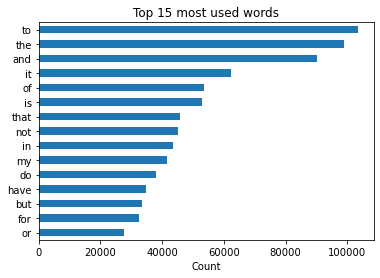

In [28]:
# Top 15 used words for both subreddits
plt.title('Top 15 most used words')
plt.xlabel('Count')
X_cv_df.sum().sort_values(ascending=False).head(15).sort_values().plot(kind='barh');

In [29]:
# adding y binarized subreddit_nsq column
X_eda = X_cv_df.merge(y, left_index=True, right_index=True)

In [30]:
X_eda.shape

(40000, 26872)

In [31]:
X_eda.groupby(by='subreddit_nsq').sum().T.sort_values(by=0, ascending=False).head(15)

subreddit_nsq,0,1
to,60292,43060
and,53710,36590
the,53239,45666
it,35331,26939
of,30847,22691
is,29780,23097
not,27734,17499
that,27159,18784
my,24766,16929
in,24166,19488


Text(0.5, 1.0, 'Top 15 most used words ordered by Too Afraid To Ask Subbredit')

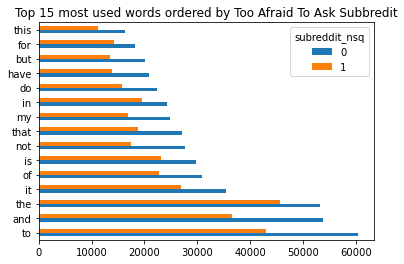

In [32]:
X_eda.groupby(by='subreddit_nsq').sum().T.sort_values(by=0, ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 most used words ordered by Too Afraid To Ask Subbredit')

In [33]:
X_eda.groupby(by='subreddit_nsq').sum().T.sort_values(by=1, ascending=False).head(15)

subreddit_nsq,0,1
the,53239,45666
to,60292,43060
and,53710,36590
it,35331,26939
is,29780,23097
of,30847,22691
in,24166,19488
that,27159,18784
not,27734,17499
my,24766,16929


Text(0.5, 1.0, 'Top 15 most used words ordered by No Stupid Questions Subreddit')

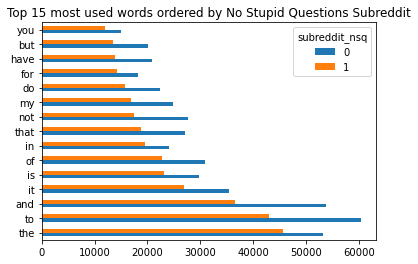

In [34]:
X_eda.groupby(by='subreddit_nsq').sum().T.sort_values(by=1, ascending=False).head(15).plot(kind='barh');
plt.title('Top 15 most used words ordered by No Stupid Questions Subreddit')

In [35]:
# set up initial test for groups
X = both['text']
y = both['subreddit_nsq']

# X = both['title']
# y = both['subreddit_nsq']

# X = both['subtext']
# y = both['subreddit_nsq']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24, stratify=y)

In [89]:
cv = CountVectorizer(min_df=2)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [90]:
rfc = RandomForestClassifier()
rfc.fit(X_train_cv, y_train)

RandomForestClassifier()

In [91]:
rfc_scores = cross_val_score(rfc, X_train_cv, y_train)
print(rfc_scores)
print(rfc_scores.mean())

[0.66666667 0.66833333 0.65       0.67283333 0.67516667]
0.6666


In [92]:
rfc_scores = cross_val_score(rfc, X_test_cv, y_test)
print(rfc_scores)
print(rfc_scores.mean())

[0.6585 0.6485 0.6465 0.6655 0.6575]
0.6552999999999999


##### Initial insights
* Appears to be a recognizable differences between the subreddits as seen in the bar charts however the intial Random Forest Classifier model indicates more similarity since the accuracy train test score was on the lower end with .6387 and .6411
* Overfit when looking at train and test scores however this may be due to the model
* Although not included here title and selftext outperformed title and selftext alone--future models will only include exclude title only and selftext only group

##### Next Steps
* Look into stemming/lemmatizing
* Attempt different models

### EDA after Preprocessing and Modeling 

##### MNB Model

In [64]:
with open ('C:/Users/mmoli/GA/projects/project_3/data/pickles/mnb.pkl', mode='rb') as pickle_in:
    mnb = pickle.load(pickle_in)

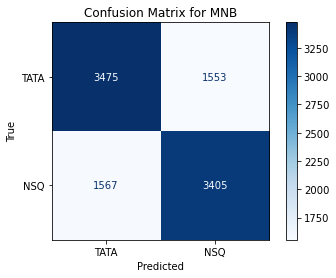

In [85]:
plot_confusion_matrix(mnb, X_test, y_test, cmap="Blues");
plt.title('Confusion Matrix for MNB')
plt.xticks(ticks=[0, 1], labels=['TATA', 'NSQ'])
plt.yticks(ticks=[0, 1], labels=['TATA', 'NSQ'])
plt.ylabel('True')
plt.xlabel('Predicted');

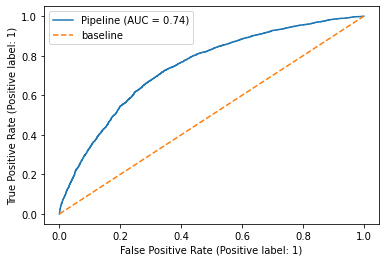

In [117]:
# ROC curve
plot_roc_curve(mnb, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend()

In [36]:
# set up EDA
X = both['text']
y = both['subreddit_nsq']

# X = both['title']
# y = both['subreddit_nsq']

# X = both['subtext']
# y = both['subreddit_nsq']

In [37]:
# vectorize title
cv = CountVectorizer(min_df=2, tokenizer=mytokenizing_stem)
cv.fit(X)
X_cv = cv.transform(X)

NameError: name 'mytokenizing_stem' is not defined

In [ ]:
# dataframe of vectorized title
X_cv_df = pd.DataFrame(X_cv.todense(),
                      columns=cv.get_feature_names())

In [ ]:
# adding y binarized subreddit_nsq column
X_eda_2 = X_cv_df.merge(y, left_index=True, right_index=True)

In [ ]:
X_eda_2

In [ ]:
X_eda_2.groupby(by='subreddit_nsq').sum().T.sort_values(by=1, ascending=False)

In [ ]:
X_eda_2.groupby(by='subreddit_nsq').sum().T.sort_values(by=1, ascending=False).head(15).plot(kind='barh')

In [ ]:
X_eda_2.groupby(by='subreddit_nsq').sum().T.sort_values(by=0, ascending=False).head(15).sort_values(by=1, ascending=False).plot(kind='barh')

In [96]:
# tranposing sorted word counts
word_comparisons = X_eda.groupby(by='subreddit_nsq').sum().T.sort_values(by=1, ascending=False).T

# words that have the same count
same_word_count = [word for word in word_comparisons if word_comparisons[word][0] == word_comparisons[word][1]]

In [94]:
print(same_word_count)

['stomach', 'photos', 'empty', 'sites', 'refer', 'fingers', 'match', 'ahead', 'privacy', 'peoples', 'followers', 'workout', 'laying', 'threw', 'objects', 'serve', 'century', 'donate', 'korea', 'ish', 'primary', 'pattern', 'vegetables', 'drives', 'cameras', 'ghost', 'stuffed', 'perform', 'combination', 'shifts', 'killer', 'preferred', 'yard', 'consuming', 'visual', 'finishing', 'vape', 'dental', 'odds', 'fits', 'colored', 'expression', 'crappy', 'capacity', 'strike', 'alternatives', 'joint', 'boat', 'soccer', 'taiwan', 'concentration', 'endless', 'blonde', 'involves', 'homo', 'heritage', 'unlikely', 'promotion', 'suits', 'breakdown', 'fried', 'terribly', 'immigration', 'fitting', 'coast', 'increases', 'curse', 'consumption', 'chess', 'patterns', 'rental', 'weapon', 'shady', 'dye', 'returning', 'thursday', 'manipulation', 'detailed', 'returned', 'paralysis', 'shitting', 'repercussions', 'alpha', 'cognitive', 'binge', 'minimal', 'collective', 'surgeries', 'questioned', 'qualified', 'tense

In [102]:
word_comparisons['stomach']

subreddit_nsq
0    136
1    136
Name: stomach, dtype: int64

* All words that are equal counts have values of 136 and less; ineffective when used as stop words

##### Insights
* Limitation of MNB; hard to locate where errors are because the distributions are relatively equal
* Same word counts are low volume, may not make a difference with the model

##### Next Steps
* Use a different model locate where errors can be minimized

### Final Model EDA

##### Imports for EDA

In [15]:
subreddits = pd.read_csv('C:/Users/mmoli/GA/projects/project_3/data/subreddits_cleaned.csv')

In [16]:
# pulled from preprocessing; used for eda pre and post conctractions
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"it\'s", "its", phrase)
    phrase = re.sub(r"What\'s", "What is", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    # phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [17]:
# expand contracted words
for col in ['text']:
    subreddits['text'] = [decontracted(each) for each in subreddits[col]]

In [18]:
def mytokenizing_stem(column):
    words = ''
    for elements in column:
        words += elements
    tokenizer = RegexpTokenizer(r'\w+')
    words_tokens = tokenizer.tokenize(words)
    p_stemmer = PorterStemmer()
    words_tokens_stem = [p_stemmer.stem(token) for token in words_tokens]
    return words_tokens_stem

##### Final Model (logreg) imports

In [19]:
with open ('C:/Users/mmoli/GA/projects/project_3/data/pickles/logreg.pkl', mode='rb') as pickle_in:
    logreg = pickle.load(pickle_in)

In [20]:
tata = subreddits[subreddits['subreddit_nsq']==0]
nsq = subreddits[subreddits['subreddit_nsq']==1]

#### TATA EDA

In [21]:
# set up EDA for groups
X = tata['text']
y = tata['subreddit_nsq']

In [93]:
# vectorize title
cv = CountVectorizer(min_df=2, tokenizer=mytokenizing_stem)
cv.fit(X)
X_cv = cv.transform(X)

C:\Users\mmoli\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [94]:
# dataframe of vectorized title
tata_df = pd.DataFrame(X_cv.todense(),
                      columns=cv.get_feature_names())

In [11]:
tata_eda = pd.DataFrame(X_cv_df.sum().sort_values(ascending=False))

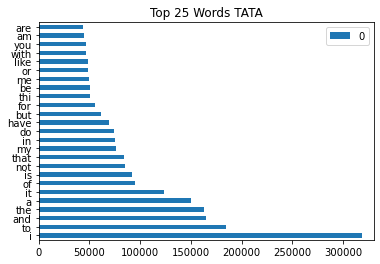

In [22]:
tata_eda.head(25).plot(kind='barh')

plt.title('Top 25 Words TATA')
plt.xlim(0, 330_000);

In [13]:
tata_eda.shape

(19897, 1)

#### NSQ EDA

In [14]:
# set up EDA for groups
X = nsq['text']
y = nsq['subreddit_nsq']

In [15]:
# vectorize title
cv = CountVectorizer(min_df=2, tokenizer=mytokenizing_stem)
cv.fit(X)
X_cv = cv.transform(X)

In [78]:
# dataframe of vectorized title
nsq_df = pd.DataFrame(X_cv.todense(),
                      columns=cv.get_feature_names())

In [81]:
nsq_df_prep = nsq_df.sum()

In [ ]:
plt.scatter(nsq_df_prep.index, nsq_df_prep)
plt.title('NSQ Word Spread')
plt.xticks(ticks=nsq_df_prep.index, labels=' ')
plt.xlabel('Words')

#### Comparisions

In [98]:
# how many words shared
shared_1 = 0
shared_2 = 0
nsq_only = 0 
tata_only = 0
for token in nsq_df.columns:
    if token in tata_df.columns:
        shared_1 += 1
    else:
        nsq_only +=1 
for token in tata_df.columns:
    if token in nsq_df.columns:
        shared_2 += 1
    else:
        tata_only +=1
        
print(shared_1)
print(shared_2)
print(nsq_only)
print(tata_only)

15367
15367
5153
4530


In [127]:
total = shared_1+nsq_only+tata_only

In [159]:
# dataframe for shared words and non-shared words
words = pd.DataFrame(columns=['Shared Words', 'NSQ only', 'TATA only', ' '])

words['Shared Words'] = [15367, round((shared_1/total)*100)]
words['NSQ only'] = [5153, round((nsq_only/total)*100)]
words['TATA only'] = [4530, round((tata_only/total)*100)]
words[' '] = ['Word Count', 'Percentage']
words.set_index(keys=' ', inplace=True)

In [160]:
words

,Shared Words,NSQ only,TATA only
,,,
Word Count,15367,5153,4530
Percentage,61,21,18


In [163]:
# how many words shared
shared_words = 0
shared_2 = 0
nsq_only_words = [] 
tata_only_words = []
for token in nsq_df.columns:
    if token not in tata_df.columns:
        nsq_only_words.append(token)
for token in tata_df.columns:
    if token not in nsq_df.columns:
        tata_only_words.append(token)

In [166]:
nsq_only_word_count = nsq_df[nsq_only_words]

In [181]:
# top 10 nsq only words
nsq_only_df = pd.DataFrame(nsq_only_word_count.sum().sort_values(ascending=False).head(10))
nsq_only_df.rename(columns={0: 'Count'}, inplace=True)
nsq_only_df

,Count
utm_medium,104
utm_sourc,86
ibb,68
ved,37
ios_app,36
iossmf,36
utm_nam,36
2c,35
android_app,34
wp,34


In [167]:
tata_only_word_count = tata_df[tata_only_words]

In [182]:
# top 10 tata only words
tata_only_df = pd.DataFrame(tata_only_word_count.sum().sort_values(ascending=False).head(10))
tata_only_df.rename(columns={0: 'Count'}, inplace=True)
tata_only_df

,Count
pedophilia,185
pedo,146
ivermectin,73
loli,66
uncircumcis,61
petito,49
mrna,44
fauci,42
euthanasia,41
castrat,38


In [ ]:
plt.scatter(wtf['index'], wtf['0_y'])

plt.scatter(wtf['index'], wtf['0_x'])

In [54]:
test_2.reset_index(inplace=True)

In [56]:
sample_2 = test_2[test_2[0]>10000]

In [50]:
sample = test[test[0]>10000]

In [42]:
test.reset_index(inplace=True)

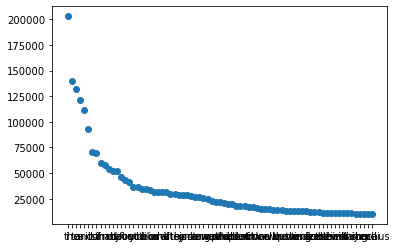

In [52]:
plt.scatter(sample['index'], sample[0])

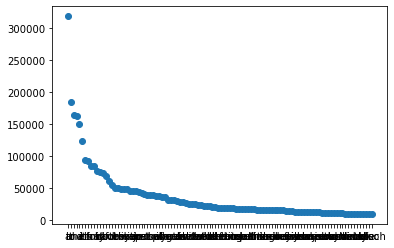

In [58]:
plt.scatter(sample_2['index'], sample_2[0])

In [59]:
tata_eda

,index,0
0,i,318986
1,to,184891
2,and,165060
3,the,162647
4,a,150245
...,...,...
19892,dingl,2
19893,saturn,2
19894,satisfactorili,2
19895,directionless,2


In [63]:
omg =pd.merge(tata_eda, nsq_eda, on='index')

In [64]:
omg

,index,0_x,0_y
0,i,318986,202991
1,to,184891,131571
2,and,165060,111785
3,the,162647,139971
4,a,150245,120833
...,...,...,...
15362,didint,2,4
15363,directori,2,9
15364,dingl,2,5
15365,saturn,2,15


In [66]:
wtf = omg[omg['0_y']<10000]

C:\Users\mmoli\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\mmoli\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 12484 missing from current font.
  font.set_text(s, 0, flags=flags)


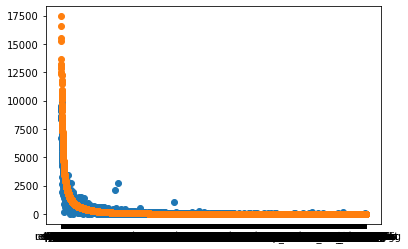

In [70]:
fml = omg[omg['0_y']>=10000]

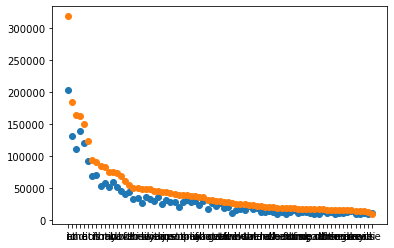

In [72]:
plt.scatter(fml['index'], fml['0_y'])
plt.scatter(fml['index'], fml['0_x'])

In [31]:
tata_eda.head(10)

,0
i,318986
to,184891
and,165060
the,162647
a,150245
it,123878
of,94558
is,92049
not,84802
that,84163


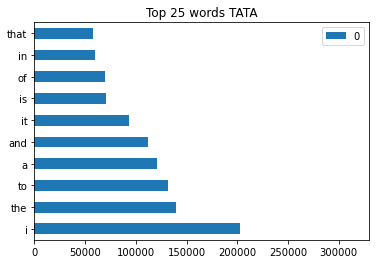

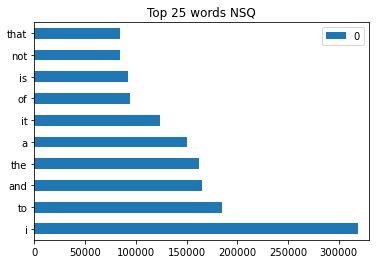

In [27]:
nsq_eda.head(10).plot(kind='barh')
plt.title('Top 25 words TATA')
plt.xlim(0, 330_000);

tata_eda.head(10).plot(kind='barh')

plt.title('Top 25 words NSQ')
plt.xlim(0, 330_000);

### Future EDA using non NLP methods

In [415]:
# title word count
subs['title_word_count'] = subs['title'].map(str.split).map(len)

# title length
subs['title_length'] = subs['title'].map(len)

# if self text present column
subs['selftext_present'] = np.where(subs['selftext']=='', 0, 1)

subs.groupby(by='subreddit').corr()[['title_word_count', 'title_length', 'selftext_present']]

title_word_count  title_length  \
subreddit                                                            
NoStupidQuestions title_word_count          1.000000      0.975417   
                  title_length              0.975417      1.000000   
                  selftext_present         -0.236334     -0.234403   
TooAfraidToAsk    title_word_count          1.000000      0.974368   
                  title_length              0.974368      1.000000   
                  selftext_present         -0.206268     -0.203985   

                                    selftext_present  
subreddit                                             
NoStupidQuestions title_word_count         -0.236334  
                  title_length             -0.234403  
                  selftext_present          1.000000  
TooAfraidToAsk    title_word_count         -0.206268  
                  title_length             -0.203985  
                  selftext_present          1.000000

In [285]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [286]:
cv = CountVectorizer(min_df=2, stop_words='english')
cv.fit(X_train)
X_train = cv.transform(X_train)
X_test = cv.transform(X_test)

In [287]:
rfc = RandomForestClassifier()

In [290]:
# do not re-run, this took forever!!!!!!
rfc_scores = cross_val_score(rfc, X_train, y_train)
print(rfc_scores)
print(rfc_scores.mean())

[0.63994944 0.6386855  0.64442314 0.64494617 0.63923637]
0.641448122434405


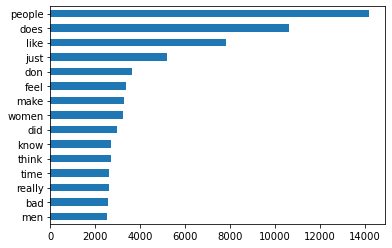

In [280]:
X_train_df.sum().sort_values(ascending=False).head(15).sort_values().plot(kind='barh');

In [270]:
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english')),
    ('mnb', MultinomialNB())
])


In [272]:
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

AttributeError: lower not found